# Setup

In [3]:
!python -c 'import matplotlib' || pip install -q matplotlib
!python -c 'import monai' || pip install -q monai
!python -c 'import nibabel' || pip install -q nibabel
!python -c 'import skimage' || pip install -q scikit-image
!python -c 'import ray' || pip install -q ray
!python -c 'import pandas' || pip install -q pandas
!python -c 'import tensorboardX' || pip install -q tensorboardX
!python -c 'import sklearn' || pip install -q scikit-learn
!python -c 'import torchmetrics' || pip install -q torchmetrics
!python -c 'import torchinfo' || pip install -q torchinfo

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'matplotlib'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'nibabel'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'skimage'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'ray'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'pandas'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'tensorboardX'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'sklearn'
Traceback (most recent call las

# Imports

In [4]:
import os
import matplotlib.pyplot as plt
# import PIL
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import nibabel as nib
import skimage.transform as skTrans
import time
import pandas
import tensorboardX
import logging
# import random

from torchinfo import summary
from torchmetrics import MeanSquaredError, MeanAbsolutePercentageError, StructuralSimilarityIndexMeasure
from functools import partial
from tqdm import tqdm
# from torch.nn import BCEWithLogitsLoss
# from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler
from monai.transforms import (
    Compose,
    RandAffine,
)
from monai.utils import set_determinism

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set paths & Initiate Logger

In [3]:
data_dir = os.path.abspath('NIfTI-files/images_structural')
checkpoint_dir = os.path.abspath('model_checkpoints')
model_path = os.path.abspath('NIfTI-files/model.pth')
print('{}\n{}\n{}\n'.format(data_dir, checkpoint_dir, model_path))

# create logger
log = logging.getLogger('model_logger')
log.propagate = False

if not log.handlers:
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter('%(levelname)s: %(message)s')
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    log.addHandler(ch)

/home/jovyan/NIfTI-files/images_structural
/home/jovyan/model_checkpoints
/home/jovyan/NIfTI-files/model.pth



# Set deterministic training for reproducibility

In [4]:
set_determinism(seed=0)

# Prepare Images

## Save Images

In [5]:
def save_images(dimensions):
    dim_start = 77
    dim_end = 78
    fileending = '2d'

    if dimensions == 3:
        dim_start = 77
        dim_end = 79
        fileending = '3d'
        
    for patient in tqdm(os.listdir(data_dir)):        
        # Get Image paths
        patient_path = os.path.join(data_dir, patient)
        t1_path = os.path.join(patient_path, patient + '_T1.nii.gz')
        t1gd_path = os.path.join(patient_path, patient + '_T1GD.nii.gz')
        t2_path = os.path.join(patient_path, patient + '_T2.nii.gz')
        flair_path = os.path.join(patient_path, patient + '_FLAIR.nii.gz')

        # Load Images
        t1 = nib.load(t1_path).get_fdata()[:,:,dim_start:dim_end]
        t1gd = nib.load(t1gd_path).get_fdata()[:,:,dim_start:dim_end]
        t2 = nib.load(t2_path).get_fdata()[:,:,dim_start:dim_end]
        flair = nib.load(flair_path).get_fdata()[:,:,dim_start:dim_end]

        # Resize images
        dim = (64, 64)
        t1 = skTrans.resize(t1, dim, order=1, preserve_range=True)
        t1gd = skTrans.resize(t1gd, dim, order=1, preserve_range=True)
        t2 = skTrans.resize(t2, dim, order=1, preserve_range=True)
        flair = skTrans.resize(flair, dim, order=1, preserve_range=True)
        
        # Mask
        t1[t1<1] = 0
        t1gd[t1gd<1] = 0
        t2[t2<1] = 0
        flair[flair<1] = 0
        
        mask = (t1!=0) & (t1gd!=0) & (t2!=0)
        
        # Normalize
        mask_flat = mask.copy().flatten()
        t1_flat = t1.copy().flatten()
        t1gd_flat = t1gd.copy().flatten()
        t2_flat = t2.copy().flatten()
        flair_flat = flair.copy().flatten()
        
        t1_mean = np.mean(t1_flat, where=mask_flat)
        t1_std = np.std(t1_flat, where=mask_flat)
        t1gd_mean = np.mean(t1gd_flat, where=mask_flat)
        t1gd_std = np.std(t1gd_flat, where=mask_flat)
        t2_mean = np.mean(t2_flat, where=mask_flat)
        t2_std = np.std(t2_flat, where=mask_flat)
        flair_mean = np.mean(flair_flat, where=mask_flat)
        flair_std = np.std(flair_flat, where=mask_flat)
        
        t1_norm = ((t1 - t1_mean) / (3 * t1_std) + 0.5) * mask
        t1gd_norm = ((t1gd - t1gd_mean) / (3 * t1gd_std) + 0.5) * mask
        t2_norm = ((t2 - t2_mean) / (3 * t2_std) + 0.5) * mask
        flair_norm = ((flair - flair_mean) / (3 * flair_std) + 0.5) * mask
        
        t1_norm[t1_norm<0] = 0
        t1_norm[t1_norm>1] = 1
        t1gd_norm[t1gd_norm<0] = 0
        t1gd_norm[t1gd_norm>1] = 1
        t2_norm[t2_norm<0] = 0
        t2_norm[t2_norm>1] = 1
        flair_norm[flair_norm<0] = 0
        flair_norm[flair_norm>1] = 1

        # Remove Images
        os.remove(os.path.join(patient_path, patient + '_T1_{}.npy'.format(fileending))) 
        os.remove(os.path.join(patient_path, patient + '_T1GD_{}.npy'.format(fileending)))
        os.remove(os.path.join(patient_path, patient + '_T2_{}.npy'.format(fileending)))
        os.remove(os.path.join(patient_path, patient + '_FLAIR_{}.npy'.format(fileending)))
        os.remove(os.path.join(patient_path, patient + '_MASK_{}.npy'.format(fileending)))

        # Save Images
        np.save(os.path.join(patient_path, patient + '_T1_{}'.format(fileending)), t1_norm)
        np.save(os.path.join(patient_path, patient + '_T1GD_{}'.format(fileending)), t1gd_norm)
        np.save(os.path.join(patient_path, patient + '_T2_{}'.format(fileending)), t2_norm)
        np.save(os.path.join(patient_path, patient + '_FLAIR_{}'.format(fileending)), flair_norm)
        np.save(os.path.join(patient_path, patient + '_MASK_{}'.format(fileending)), mask)

#save_images(3)

## Load Images

In [6]:
def load_images(dimensions):
    fileending = '3d' if dimensions == 3 else '2d'

    # All class names
    class_names = ['t1', 't1gd', 't2', 'flair', 'mask']

    # All Images
    image_files = []
    image_flairs = []
    image_masks = []
    patients = []
    
    for patient in tqdm(os.listdir(data_dir)):
        # Get Image paths
        patients.append(patient)
        patient_path = os.path.join(data_dir, patient)
        t1_path = os.path.join(patient_path, patient + '_T1_{}.npy'.format(fileending))
        t1gd_path = os.path.join(patient_path, patient + '_T1GD_{}.npy'.format(fileending))
        t2_path = os.path.join(patient_path, patient + '_T2_{}.npy'.format(fileending))
        flair_path = os.path.join(patient_path, patient + '_FLAIR_{}.npy'.format(fileending))
        mask_path = os.path.join(patient_path, patient + '_MASK_{}.npy'.format(fileending))

        # Concatenate images
        image_files.append([t1_path, t1gd_path, t2_path])
        image_flairs.append(flair_path)
        image_masks.append(mask_path)
    
    return np.array(image_files), np.array(image_flairs), np.array(image_masks)
    
image_files, image_flairs, image_masks = load_images(3)
num_total = len(image_files)
print(f'Total image count: {num_total}')

100%|██████████| 671/671 [00:00<00:00, 99875.01it/s]

Total image count: 671


# Prepare training, validation and test data lists

In [7]:
val_frac = 0.15
test_frac = 0.15
indices = np.arange(num_total)
np.random.shuffle(indices)

test_split = int(test_frac * num_total)
val_split = int(val_frac * num_total) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files[i] for i in train_indices]
train_y = [image_flairs[i] for i in train_indices]
train_mask = [image_masks[i] for i in train_indices]
val_x = [image_files[i] for i in val_indices]
val_y = [image_flairs[i] for i in val_indices]
val_mask = [image_masks[i] for i in val_indices]
test_x = [image_files[i] for i in test_indices]
test_y = [image_flairs[i] for i in test_indices]
test_mask = [image_masks[i] for i in test_indices]

print(f'Training count: {len(train_x)}, Validation count: ' f'{len(val_x)}, Test count: {len(test_x)}')

Training count: 471, Validation count: 100, Test count: 100


# MONAI

## Define transforms

In [8]:
degrees = 10*np.pi/180
shear_range = (0.15, 0.15, 0)
scale_range = (0.15, 0.15, 0.15)

train_transforms = Compose([
    RandAffine(prob=0.3, padding_mode='zeros', rotate_range=(0, 0, degrees), mode='bilinear'),
    RandAffine(prob=0.3, padding_mode='zeros', shear_range=shear_range, mode='bilinear'),
    RandAffine(prob=0.3, padding_mode='zeros', scale_range=scale_range, mode='bilinear')
])
train_transforms_flair = Compose([
    RandAffine(prob=0.3, padding_mode='zeros', rotate_range=(0, 0, degrees), mode='bilinear'),
    RandAffine(prob=0.3, padding_mode='zeros', shear_range=shear_range, mode='bilinear'),
    RandAffine(prob=0.3, padding_mode='zeros', scale_range=scale_range, mode='bilinear')
])
train_transforms_mask = Compose([
    RandAffine(prob=0.3, padding_mode='zeros', rotate_range=(0, 0, degrees), mode='nearest'),
    RandAffine(prob=0.3, padding_mode='zeros', shear_range=shear_range, mode='nearest'),
    RandAffine(prob=0.3, padding_mode='zeros', scale_range=scale_range, mode='nearest')
])

val_transforms = Compose([])
val_transforms_flair = Compose([])
val_transforms_mask = Compose([])

test_transforms = Compose([])
test_transforms_flair = Compose([])
test_transforms_mask = Compose([])

## Define Dataset and Dataloader

In [9]:
class NIfTIDataset(Dataset):
    def __init__(self, input_contrats, flair_contrasts, masks, transforms, dimensions):
        self.input_contrats = input_contrats
        self.flair_contrasts = flair_contrasts
        self.masks = masks
        self.transforms = transforms[0]
        self.transforms_flair = transforms[1]
        self.transforms_mask = transforms[2]
        self.dimensions = dimensions

    def __len__(self):
        return len(self.input_contrats)

    def __getitem__(self, index):
        # Load Images
        t1 = np.load(self.input_contrats[index][0])[:,:,0:2]
        t1gd = np.load(self.input_contrats[index][1])[:,:,0:2]
        t2 = np.load(self.input_contrats[index][2])[:,:,0:2]
        flair = np.load(self.flair_contrasts[index])[:,:,0:2]
        mask = np.load(self.masks[index])[:,:,0:2]
        
        dim_contrast = (3, 64, 64)
        dim_flair = (1, 64, 64)

        if self.dimensions == 3:
            dim_contrast = (3, 64, 64, 2)
            dim_flair = (1, 64, 64, 2)
            
        if self.dimensions == 2:
            t1 = np.squeeze(t1, -1)
            t1gd = np.squeeze(t1gd, -1)
            t2 = np.squeeze(t2, -1)
            flair = np.squeeze(flair, -1)
            mask = np.squeeze(mask, -1)
        
        # Concatenate images            
        concat_constrasts = np.zeros(dim_contrast, dtype=np.float32)
        concat_constrasts[0] = t1.astype(np.float32)
        concat_constrasts[1] = t1gd.astype(np.float32)
        concat_constrasts[2] = t2.astype(np.float32)
        concat_constrasts = torch.from_numpy(concat_constrasts)

        flair_channel = np.zeros(dim_flair, dtype=np.float32)
        flair_channel[0] = flair.astype(np.float32)
        flair_channel = torch.from_numpy(flair_channel)

        mask_channel = np.zeros(dim_flair, dtype=np.float32)
        mask_channel[0] = mask.astype(np.float32)
        mask_channel = torch.from_numpy(mask_channel)
        
        train = self.transforms(concat_constrasts)
        flair = self.transforms_flair(flair_channel)
        mask = self.transforms_mask(mask_channel)
        return train, flair, mask 

# U-Net Generator

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [11]:
model = UNET(in_channels=3, out_channels=1, features=[64, 128, 256, 512])
print(summary(model, input_size=(10, 3, 64, 64)))
print(model)

Layer (type:depth-idx)                   Output Shape              Param #
UNET                                     [10, 1, 64, 64]           --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [10, 64, 64, 64]          --
│    │    └─Sequential: 3-1              [10, 64, 64, 64]          38,848
├─MaxPool2d: 1-2                         [10, 64, 32, 32]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [10, 128, 32, 32]         --
│    │    └─Sequential: 3-2              [10, 128, 32, 32]         221,696
├─MaxPool2d: 1-4                         [10, 128, 16, 16]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [10, 256, 16, 16]         --
│    │    └─Sequential: 3-3              [10, 256, 16, 16]         885,760
├─MaxPool2d: 1-6                         [10

# Train & Validation

## Utils

In [12]:
def show_img(inputs, labels, masks, outputs):
    plt.style.use('dark_background')
    plt.subplots(1, 6, figsize=(16, 16))
    
    # T1
    plt.subplot(1, 6, 1)
    plt.xlabel('T1')
    plt.imshow(inputs[0,:,:,0], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # T1GD
    plt.subplot(1, 6, 2)
    plt.xlabel('T1GD')
    plt.imshow(inputs[1,:,:,0], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # T2
    plt.subplot(1, 6, 3)
    plt.xlabel('T2')
    plt.imshow(inputs[2,:,:,0], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # Real Flair
    plt.subplot(1, 6, 4)
    plt.xlabel('Real Flair')
    plt.imshow(labels[0,:,:,-1], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # Generated Flair
    plt.subplot(1, 6, 5)
    plt.xlabel('Generated Flair')
    plt.imshow(outputs[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # Mask
    plt.subplot(1, 6, 6)
    plt.xlabel('Mask')
    plt.imshow(masks[0,:,:,0], cmap='gray', vmin=0, vmax=1)
    plt.grid(False)

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    plt.tight_layout()
    plt.show()

## Train function

In [25]:
def train_model(config, train_ds, val_ds, log_level=logging.WARNING, tune=False):
    torch.cuda.empty_cache()
    
    batch_size = config['batch_size']
    epochs = config['epochs']
    device = config['device']
    start_epoch = 1
    log.setLevel(log_level)

    model = UNET(in_channels=3, out_channels=1, features=config['features']).to(device)
    
    # Early stopping
    last_loss = 100
    patience = 5
    trigger_times = 0
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    loss_function = config['loss'].to(device)
    ssim_loss = StructuralSimilarityIndexMeasure().to(device)
    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()
    mape_loss = MeanAbsolutePercentageError().to(device)
    rmse_loss = MeanSquaredError(squared=False).to(device)
    
    global train_loss_mse
    train_loss_mse = np.array([])
    global train_loss_mae
    train_loss_mae = np.array([])
    global val_loss_mse
    val_loss_mse = np.array([])
    global val_loss_mae
    val_loss_mae = np.array([])
    
    if tune:
        checkpoint = session.get_checkpoint()

        if checkpoint:
            checkpoint_state = checkpoint.to_dict()
            start_epoch = checkpoint_state["epoch"]
            model.load_state_dict(checkpoint_state["model_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=1)

    for epoch in range(start_epoch, epochs + 1):
        # Training
        if log_level <= logging.WARNING:
            log.info('-'*50)
            log.info('Training')
            log.info('-'*50)
            log.info('Train Epoch: %d/%d', epoch, epochs)
        
        model.train()
        batches_trained = 0
        running_loss = 0.0
        baseline_running_loss = 0.0
        ssim_sum = 0
        ssim_base_sum = 0
        mse_sum = 0
        mse_base_sum = 0
        mae_sum = 0
        mae_base_sum = 0
        mape_sum = 0
        mape_base_sum = 0
        rmse_sum = 0
        rmse_base_sum = 0
        
        for times, (inputs, labels, masks) in enumerate(train_loader, 1):
            (inputs, labels, masks) = (inputs.to(device), labels.to(device), masks.to(device))
            train_len = len(train_loader.dataset) * inputs.shape[-1]
            
            for i in range(inputs.shape[-1]):
                batches_trained += len(inputs)
                
                inputs_s = inputs[:,:,:,:,i].reshape(len(inputs), 3, 64, 64)
                masks_s = masks[:,:,:,:,i].reshape(len(inputs), 1, 64, 64)
                labels_s = labels[:,:,:,:,i].reshape(len(inputs), 1, 64, 64)
                
                # Zero the gradients
                optimizer.zero_grad()

                # Forward and backward propagation            
                output = model(inputs_s)
                output *= masks_s

                loss = loss_function(output, labels_s)
                running_loss += loss.item()

                loss.backward()
                optimizer.step()

                baseline = masks_s * 0.5
                baseline_loss = loss_function(baseline, labels_s)
                baseline_running_loss += baseline_loss.item()

                ssim = ssim_loss(output, labels_s)
                ssim_sum += ssim
                ssim_base = ssim_loss(baseline, labels_s)
                ssim_base_sum += ssim_base
                mse = mse_loss(output, labels_s)
                mse_sum += mse
                mse_base = mse_loss(baseline, labels_s)
                mse_base_sum += mse_base
                mae = mae_loss(output, labels_s)
                mae_sum += mae
                mae_base = mae_loss(baseline, labels_s)
                mae_base_sum += mae_base
                mape = mape_loss(output, labels_s)
                mape_sum += mape
                mape_base = mape_loss(baseline, labels_s)
                mape_base_sum += mape_base
                rmse = rmse_loss(output, labels_s)
                rmse_sum += rmse
                rmse_base = rmse_loss(baseline, labels_s)
                rmse_base_sum += rmse_base

                # Show progress
                log.debug('Train Epoch: %d/%d [%d/%d (%.0f%%)] Image: %d\nLoss: %.3f/%.3f\tSSIM: %.3f/%.3f\tMSE: %.3f/%.3f\tMAE: %.3f/%.3f\tMAPE: %.3f/%.3f\tRMSE: %.3f/%.3f\n',
                          epoch, epochs, batches_trained, train_len, 100. * batches_trained / train_len, i, loss, 
                          baseline_loss, ssim, ssim_base, mse, mse_base, mae, mae_base, mape, mape_base, rmse, rmse_base)
        
        times *= inputs.shape[-1]
        train_loss_mse = np.append(train_loss_mse, mse_sum.cpu().detach().numpy() / times)
        train_loss_mae = np.append(train_loss_mae, mae_sum.cpu().detach().numpy() / times)
        log.debug('Average loss: %.3f/%.3f\tAverage SSIM: %.3f/%.3f\tAverage MSE: %.3f/%.3f\tAverage MAE: %.3f/%.3f\tAverage MAPE: %.3f/%.3f\tAverage RMSE: %.3f/%.3f', 
                  running_loss / times, baseline_running_loss / times, ssim_sum / times, ssim_base_sum / times, 
                  mse_sum / times, mse_base_sum / times, mae_sum / times, mae_base_sum / times, mape_sum / times, 
                  mape_base_sum / times, rmse_sum / times, rmse_base_sum / times)
        
        if log_level <= logging.INFO:
            img_input = inputs[-1].cpu().detach() 
            img_label = labels[-1].cpu().detach() 
            img_mask = masks[-1].cpu().detach() 
            img_output = output[-1].cpu().detach().numpy()

            log.info('Training Image')
            show_img(img_input, img_label, img_mask, img_output)
        
        # Validation
        if log_level <= logging.WARNING:
            log.info('-'*50)
            log.info('Validation')
            log.info('-'*50)
            log.info('Validate Epoch: %d/%d', epoch, epochs)
        
        model.eval()
        batches_trained = 0
        running_loss = 0.0
        baseline_running_loss = 0.0
        ssim_sum = 0
        ssim_base_sum = 0
        mse_sum = 0
        mse_base_sum = 0
        mae_sum = 0
        mae_base_sum = 0
        mape_sum = 0
        mape_base_sum = 0
        rmse_sum = 0
        rmse_base_sum = 0

        with torch.no_grad():
            for times, (inputs, labels, masks) in enumerate(val_loader, 1):
                (inputs, labels, masks) = (inputs.to(device), labels.to(device), masks.to(device))
                val_len = len(val_loader.dataset) * inputs.shape[-1]
                
                for i in range(inputs.shape[-1]):
                    batches_trained += len(inputs)
                    
                    inputs_s = inputs[:,:,:,:,i].reshape(len(inputs), 3, 64, 64)
                    masks_s = masks[:,:,:,:,i].reshape(len(inputs), 1, 64, 64)
                    labels_s = labels[:,:,:,:,i].reshape(len(inputs), 1, 64, 64)

                    output = model(inputs_s)
                    output *= masks_s
                    loss = loss_function(output, labels_s)
                    running_loss += loss.item()
                    
                    baseline = masks_s * 0.5
                    baseline_loss = loss_function(baseline, labels_s)
                    baseline_running_loss += baseline_loss.item()
                    
                    ssim = ssim_loss(output, labels_s)
                    ssim_sum += ssim
                    ssim_base = ssim_loss(baseline, labels_s)
                    ssim_base_sum += ssim_base
                    mse = mse_loss(output, labels_s)
                    mse_sum += mse
                    mse_base = mse_loss(baseline, labels_s)
                    mse_base_sum += mse_base
                    mae = mae_loss(output, labels_s)
                    mae_sum += mae
                    mae_base = mae_loss(baseline, labels_s)
                    mae_base_sum += mae_base
                    mape = mape_loss(output, labels_s)
                    mape_sum += mape
                    mape_base = mape_loss(baseline, labels_s)
                    mape_base_sum += mape_base
                    rmse = rmse_loss(output, labels_s)
                    rmse_sum += rmse
                    rmse_base = rmse_loss(baseline, labels_s)
                    rmse_base_sum += rmse_base
                    
                    # Show progress
                    log.debug('Validate Epoch: %d/%d [%d/%d (%.0f%%)] Image: %d\nLoss: %.3f/%.3f\tSSIM: %.3f/%.3f\tMSE: %.3f/%.3f\tMAE: %.3f/%.3f\tMAPE: %.3f/%.3f\tRMSE: %.3f/%.3f\n',
                              epoch, epochs, batches_trained, val_len, 100. * batches_trained / val_len, i, loss, 
                              baseline_loss, ssim, ssim_base, mse, mse_base, mae, mae_base, mape, mape_base, rmse, rmse_base)

            times *= inputs.shape[-1]
            val_loss_mse = np.append(val_loss_mse, mse_sum.cpu().detach().numpy() / times)
            val_loss_mae = np.append(val_loss_mae, mae_sum.cpu().detach().numpy() / times)
            log.debug('Average loss: %.3f/%.3f\tAverage SSIM: %.3f/%.3f\tAverage MSE: %.3f/%.3f\tAverage MAE: %.3f/%.3f\tAverage MAPE: %.3f/%.3f\tAverage RMSE: %.3f/%.3f', 
                      running_loss / times, baseline_running_loss / times, ssim_sum / times, ssim_base_sum / times, 
                      mse_sum / times, mse_base_sum / times, mae_sum / times, mae_base_sum / times, mape_sum / times, 
                      mape_base_sum / times, rmse_sum / times, rmse_base_sum / times)

            if log_level <= logging.INFO:
                img_label = labels[-1].cpu().detach() 
                img_input = inputs[-1].cpu().detach() 
                img_mask = masks[-1].cpu().detach() 
                img_output = output[-1].cpu().detach().numpy()

                log.info('Validation Image')
                show_img(img_input, img_label, img_mask, img_output)
                
        if tune:
            checkpoint_data = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }
            checkpoint = Checkpoint.from_dict(checkpoint_data)

            session.report(
                {'mae': mae_sum.cpu().detach().numpy() / times, 'mse': mse_sum.cpu().detach().numpy() / times, 'mape': mape_sum.cpu().detach().numpy() / times, 'rmse': rmse_sum.cpu().detach().numpy() / times, 'ssim': ssim_sum.cpu().detach().numpy() / times},
                checkpoint=checkpoint,
            )

        torch.cuda.empty_cache()

        # Early stopping
        current_loss = running_loss / times
        log.debug('The Current Loss: %.3f', current_loss)

        if current_loss >= last_loss:
            trigger_times += 1
            log.debug('Trigger Times: %d', trigger_times)

            if trigger_times >= patience:
                log.debug('Early stopping!\nStart to test process.')
                return

        else:
            log.debug('trigger times: 0')
            trigger_times = 0

        last_loss = current_loss

    return model

## Train the model

In [18]:
train_ds = NIfTIDataset(train_x, train_y, train_mask, [train_transforms, train_transforms_flair, train_transforms_mask], 3)
val_ds = NIfTIDataset(val_x, val_y, val_mask, [val_transforms, val_transforms_flair, val_transforms_mask], 3)

config = {
    'lr': 1e-3,
    'batch_size': 10,
    'loss': nn.L1Loss(),
    'features': [64, 128, 256, 512],
    'epochs': 100,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

#fin_model = train_model(config, train_ds, val_ds, log_level=logging.DEBUG, tune=False)

In [15]:
def plot_loss():
    epochs = range(1, config['epochs']+1)

    plt.style.use('dark_background')
    plt.subplots(1, 2, figsize=(16, 8))

    plt.subplot(1, 2, 1)
    # Add in a title and axes labels
    plt.title('Training and Validation Loss MAE')
    plt.xticks(np.arange(1, epochs[-1]+1, 5) - 1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Plot and label the training and validation loss values
    plt.plot(epochs, train_loss_mae, label='Training Loss MAE')
    plt.plot(epochs, val_loss_mae, label='Validation Loss MAE')
    # plt.plot(epochs, test_loss_mae, label='Testing Loss MAE')

    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    # Add in a title and axes labels
    plt.title('Training and Validation Loss MSE')
    plt.xticks(np.arange(1, epochs[-1]+1, 5) - 1)
    plt.xlabel('Epochs')

    plt.ylabel('Loss')

    # Plot and label the training and validation loss values
    plt.plot(epochs, train_loss_mse, label='Training Loss MSE')
    plt.plot(epochs, val_loss_mse, label='Validation Loss MSE')
    # plt.plot(epochs, test_loss_mse, label='Testing Loss MSE')

    # Display the plot
    plt.legend(loc='best')
    plt.show()

    print('Train MAE: {}\nVal MAE: {}\nTest MAE: {}\n\nTrain MSE: {}\nVal MSE: {}\nTest MSE: {}'.format(
          ['%.5f' % elem for elem in train_loss_mae], ['%.5f' % elem for elem in val_loss_mae], ['%.5f' % elem for elem in test_loss_mae],
          ['%.5f' % elem for elem in train_loss_mse], ['%.5f' % elem for elem in val_loss_mse], ['%.5f' % elem for elem in test_loss_mse]))
    
# plot_loss()

## Hyperparameter tuning

In [21]:
def main(num_trials=10, num_epochs=10, cpus_per_trial=1, gpus_per_trial=1):

    config = {
        'lr': tune.choice([1e-5, 1e-3]),
        'batch_size': tune.choice([6, 12]),
        'loss': nn.L1Loss(),
        'features': tune.choice([[32, 64, 128, 256], [64, 128, 256, 512]]),
        'epochs': num_epochs,
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    }

    scheduler = ASHAScheduler(
        metric='mae',
        mode='min',
        max_t=config['epochs'],
        grace_period=1,
        reduction_factor=2,
    )

    result = tune.run(
        partial(train_model, train_ds=train_ds, val_ds=val_ds, log_level=logging.ERROR, tune=True),
        resources_per_trial={'cpu': cpus_per_trial, 'gpu': gpus_per_trial},
        config=config,
        num_samples=num_trials,
        scheduler=scheduler
    )
    
    best_trial = result.get_best_trial('mae', 'min')
    print('-'*50)
    print('Best trial config: {}'.format(best_trial.config))
    print('Best trial final validation mae: {}'.format(best_trial.last_result['mae']))
    print('Best trial final validation mse: {}'.format(best_trial.last_result['mse']))
    print('Best trial final validation mape: {}'.format(best_trial.last_result['mape']))
    print('Best trial final validation rmse: {}'.format(best_trial.last_result['rmse']))
    print('Best trial final validation ssim: {}'.format(best_trial.last_result['ssim']))
    print('-'*50)
    
    return best_trial

In [17]:
set_determinism(seed=int(time.time()))
best_model = main(15, 70, 7, 1)

2023-06-01 18:15:48,519	WARNING utils.py:625 -- Ray currently does not support initializing Raywith fractional cpus. Your num_cpus will be truncated from 7.5 to 7.
2023-06-01 18:15:48,524	WARNING services.py:1816 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 11653120 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.64gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-06-01 18:15:48,878	INFO worker.py:1625 -- Started a local Ray instance.
2023-06-01 18:15:49,569	INFO tune.py:218 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


Trial name,date,done,hostname,iterations_since_restore,mae,mape,mse,node_ip,pid,rmse,should_checkpoint,ssim,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_model_563b0_00000,2023-06-01_18-29-21,True,jupyter-jbitte01,70,0.0247678,838.048,0.00368543,10.1.100.124,3551320,0.0603556,True,0.892152,807.26,11.9758,807.26,1685644161,70,563b0_00000
train_model_563b0_00001,2023-06-01_18-29-36,True,jupyter-jbitte01,1,0.124424,7711.62,0.0757701,10.1.100.124,3588464,0.275199,True,0.552244,10.8283,10.8283,10.8283,1685644176,1,563b0_00001
train_model_563b0_00002,2023-06-01_18-29-51,True,jupyter-jbitte01,1,0.0942059,6481.91,0.0431759,10.1.100.124,3589087,0.207704,True,0.549451,10.5122,10.5122,10.5122,1685644191,1,563b0_00002
train_model_563b0_00003,2023-06-01_18-38-19,True,jupyter-jbitte01,70,0.0220055,418.793,0.00305265,10.1.100.124,3589710,0.0548938,True,0.917591,504.751,7.19084,504.751,1685644699,70,563b0_00003
train_model_563b0_00004,2023-06-01_18-55-29,True,jupyter-jbitte01,70,0.0207287,443.48,0.00277452,10.1.100.124,3626256,0.0520359,True,0.921445,1026.02,14.6799,1026.02,1685645729,70,563b0_00004
train_model_563b0_00005,2023-06-01_18-57-06,True,jupyter-jbitte01,8,0.0303144,727.042,0.00528943,10.1.100.124,3662911,0.0723383,True,0.874962,93.4762,11.4034,93.4762,1685645826,8,563b0_00005
train_model_563b0_00006,2023-06-01_18-57-20,True,jupyter-jbitte01,1,0.220334,10846.8,0.16702,10.1.100.124,3667189,0.40835,True,0.618239,10.1444,10.1444,10.1444,1685645840,1,563b0_00006
train_model_563b0_00007,2023-06-01_18-57-37,True,jupyter-jbitte01,1,0.0712587,5322.67,0.0259053,10.1.100.124,3667812,0.160859,True,0.636589,13.1183,13.1183,13.1183,1685645857,1,563b0_00007
train_model_563b0_00008,2023-06-01_18-58-30,True,jupyter-jbitte01,4,0.0475159,588.078,0.0105446,10.1.100.124,3668436,0.102575,True,0.837763,49.0776,11.4373,49.0776,1685645910,4,563b0_00008
train_model_563b0_00009,2023-06-01_18-59-06,True,jupyter-jbitte01,2,0.0432199,2568.71,0.00947072,10.1.100.124,3670623,0.0970576,True,0.765262,32.6309,14.6535,32.6309,1685645946,2,563b0_00009


2023-06-01 19:07:42,427	INFO tune.py:945 -- Total run time: 3112.86 seconds (3112.77 seconds for the tuning loop).


--------------------------------------------------
Best trial config: {'lr': 0.001, 'batch_size': 6, 'loss': L1Loss(), 'features': [64, 128, 256, 512], 'epochs': 70, 'device': device(type='cuda')}
Best trial final validation mae: 0.02072873360970441
Best trial final validation mse: 0.002774516010985655
Best trial final validation mape: 443.47960707720586
Best trial final validation rmse: 0.05203589972327737
Best trial final validation ssim: 0.9214450050802792
--------------------------------------------------


## Testing

INFO: Testing: 6/200 (3%) Image: 0
MSE: 0.003/0.020	MAE: 0.020/0.059	MAPE: 477.276/11598.852	RMSE: 0.051/0.142	SSIM: 0.926/0.488

INFO: Testing: 12/200 (6%) Image: 1
MSE: 0.003/0.020	MAE: 0.020/0.059	MAPE: 519.052/11564.095	RMSE: 0.050/0.143	SSIM: 0.927/0.492

INFO: Testing: 18/200 (9%) Image: 0
MSE: 0.004/0.022	MAE: 0.025/0.066	MAPE: 664.781/14241.964	RMSE: 0.060/0.149	SSIM: 0.910/0.457

INFO: Testing: 24/200 (12%) Image: 1
MSE: 0.004/0.022	MAE: 0.025/0.066	MAPE: 691.397/14363.729	RMSE: 0.061/0.150	SSIM: 0.907/0.459

INFO: Testing: 30/200 (15%) Image: 0
MSE: 0.003/0.021	MAE: 0.022/0.065	MAPE: 476.057/11529.147	RMSE: 0.057/0.144	SSIM: 0.918/0.471

INFO: Testing: 36/200 (18%) Image: 1
MSE: 0.003/0.021	MAE: 0.022/0.066	MAPE: 472.992/11216.184	RMSE: 0.058/0.144	SSIM: 0.918/0.472

INFO: Testing: 42/200 (21%) Image: 0
MSE: 0.003/0.021	MAE: 0.020/0.064	MAPE: 673.461/13511.466	RMSE: 0.052/0.146	SSIM: 0.933/0.460

INFO: Testing: 48/200 (24%) Image: 1
MSE: 0.003/0.021	MAE: 0.020/0.064	MAPE: 673

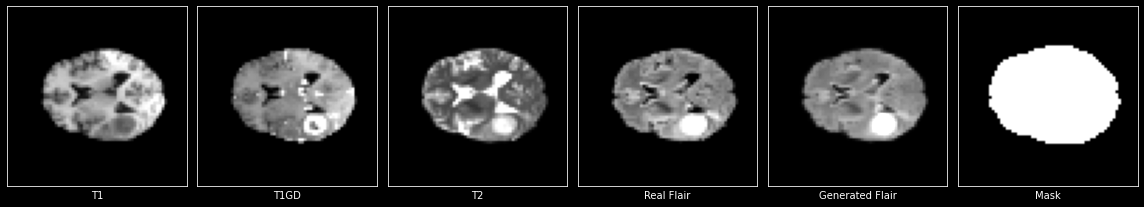

In [44]:
test_ds = NIfTIDataset(test_x, test_y, test_mask, [test_transforms, test_transforms_flair, test_transforms_mask], 3)

def test_best_model(best_result, test_ds):
    device = best_result.config['device']
    batch_size = best_result.config['batch_size']
    
    best_trained_model = UNET(in_channels=3, out_channels=1, features=best_result.config['features']).to(device)
    
    test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=1)
    
    best_checkpoint = best_result.checkpoint.to_air_checkpoint()
    best_checkpoint_data = best_checkpoint.to_dict()
    best_trained_model.load_state_dict(best_checkpoint_data["model_state_dict"])
    
    ssim_loss = StructuralSimilarityIndexMeasure().to(device)
    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()
    mape_loss = MeanAbsolutePercentageError().to(device)
    rmse_loss = MeanSquaredError(squared=False).to(device)
    
    global test_loss_mse
    test_loss_mse = np.array([])
    global test_loss_mae
    test_loss_mae = np.array([])
    
    # Testing
    batches_trained = 0
    running_loss = 0.0
    baseline_running_loss = 0.0
    ssim_sum = 0
    ssim_base_sum = 0
    mse_sum = 0
    mse_base_sum = 0
    mae_sum = 0
    mae_base_sum = 0
    mape_sum = 0
    mape_base_sum = 0
    rmse_sum = 0
    rmse_base_sum = 0

    with torch.no_grad():
        for times, (inputs, labels, masks) in enumerate(test_loader, 1):
            (inputs, labels, masks) = (inputs.to(device), labels.to(device), masks.to(device))
            test_len = len(test_loader.dataset) * inputs.shape[-1]

            for i in range(inputs.shape[-1]):
                batches_trained += len(inputs)

                inputs_s = inputs[:,:,:,:,i].reshape(len(inputs), 3, 64, 64)
                masks_s = masks[:,:,:,:,i].reshape(len(inputs), 1, 64, 64)
                labels_s = labels[:,:,:,:,i].reshape(len(inputs), 1, 64, 64)

                output = best_trained_model(inputs_s)
                output *= masks_s

                baseline = masks_s * 0.5

                ssim = ssim_loss(output, labels_s)
                ssim_sum += ssim
                ssim_base = ssim_loss(baseline, labels_s)
                ssim_base_sum += ssim_base
                mse = mse_loss(output, labels_s)
                mse_sum += mse
                mse_base = mse_loss(baseline, labels_s)
                mse_base_sum += mse_base
                mae = mae_loss(output, labels_s)
                mae_sum += mae
                mae_base = mae_loss(baseline, labels_s)
                mae_base_sum += mae_base
                mape = mape_loss(output, labels_s)
                mape_sum += mape
                mape_base = mape_loss(baseline, labels_s)
                mape_base_sum += mape_base
                rmse = rmse_loss(output, labels_s)
                rmse_sum += rmse
                rmse_base = rmse_loss(baseline, labels_s)
                rmse_base_sum += rmse_base

                # Show progress
                log.info('Testing: %d/%d (%.0f%%) Image: %d\nMSE: %.3f/%.3f\tMAE: %.3f/%.3f\tMAPE: %.3f/%.3f\tRMSE: %.3f/%.3f\tSSIM: %.3f/%.3f\n',
                          batches_trained, test_len, 100. * batches_trained / test_len, i, mse, mse_base, mae, mae_base, mape, mape_base, rmse, rmse_base, ssim, ssim_base)

        times *= inputs.shape[-1]
        test_loss_mse = np.append(test_loss_mse, mse_sum.cpu().detach().numpy() / times)
        test_loss_mae = np.append(test_loss_mae, mae_sum.cpu().detach().numpy() / times)
        log.info('Average MSE: %.3f/%.3f\tAverage MAE: %.3f/%.3f\tAverage MAPE: %.3f/%.3f\tAverage RMSE: %.3f/%.3f\tAverage SSIM: %.3f/%.3f', 
                  mse_sum / times, mse_base_sum / times, mae_sum / times, mae_base_sum / times, mape_sum / times, mape_base_sum / times, rmse_sum / times, rmse_base_sum / times, ssim_sum / times, ssim_base_sum / times)

        img_label = labels[-1].cpu().detach() 
        img_input = inputs[-1].cpu().detach() 
        img_mask = masks[-1].cpu().detach() 
        img_output = output[-1].cpu().detach().numpy()

        log.info('Testing Image')
        show_img(img_input, img_label, img_mask, img_output)

test_best_model(best_model, test_ds)